In [1]:
from operator import pos
import numpy as np
import pandas as pd
import tensorflow as tf
import time

import os
os.chdir("/home/anna/GitHub/Block_Importance_Quantification")
from src.M_ANN.multiblock_network import multiblock_network
import src.M_ANN.help_functions as help_functions
from src.M_ANN.help_functions import remove_outliers

from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, matthews_corrcoef, f1_score, recall_score, precision_score, auc, roc_curve, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
car = pd.read_csv("data/servo/servo.data", header=None)
car.columns = ["motor", "screw", "pgain", "vgain", "target"]
car

,motor,screw,pgain,vgain,target
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251
...,...,...,...,...,...
162,B,C,3,2,4.499986
163,B,E,3,1,3.699967
164,C,D,4,3,0.956256
165,A,B,3,2,4.499986


In [4]:
train = car.iloc[:120,:-1]
y_train = car.iloc[:120,-1]
test = car.iloc[120:,:-1]
y_test = car.iloc[120:,-1]

In [5]:
data_blocks = []
data_blocks_test = []
for i in range(2):
    data_blocks.append(pd.get_dummies(train.iloc[:,i], prefix = train.columns[i]))
    data_blocks_test.append(pd.get_dummies(test.iloc[:,i], prefix = test.columns[i]))
for i in np.arange(2,4):
    data_blocks.append(train.iloc[:,i])
    data_blocks_test.append(test.iloc[:,i])

In [6]:
def build_block_network(data, activation="elu", learning_rate=0.1, prob = "class", epochs=1000):
    network = multiblock_network()

    for b in data:
            structure1 = [Input(shape=(np.shape(b)[1],)),
                          #Dense(4, activation=activation),
                  Dense(np.shape(b)[1], activation="linear")]
            network.define_block_net(structure1.copy())

    structure = [Dense(12, activation=activation),
                 Dense(8, activation=activation),
                 Dense(4, activation=activation),
                 Dense(2, activation=activation),
                 Dense(1, activation="linear")]
    #concatenate
    network.define_block_concatenation(structure=structure)

    opt = tf.keras.optimizers.RMSprop()


    if prob =="class":
        network.compile(loss="binary_crossentropy", optimizer=opt,
                       metrics=[help_functions.matthews_correlation, help_functions.f1_m])
    elif prob == "regression":
        network.compile(loss='mean_squared_error', optimizer=opt,
                        metrics=[help_functions.coeff_determination])

    return network

In [7]:
target = pd.DataFrame(y_train)

results = {}
results_train = {}
prob="regression"

batch_size = [64,32]
epochs = [200, 500]
learn_rate = [1,5,8,]
activation =["elu", "swish", "relu"]

for b in batch_size:
    for e in epochs:
        for l in learn_rate:
            for a in activation:
                print(b, e, l, a)
                if prob=="class":
                    skf = StratifiedKFold(n_splits=3)
                    X = np.zeros(len(target))
                    y = target
                else:
                    skf = KFold(n_splits=3)
                    X = data_blocks[0]
                    y = None
                avg_performance = []
                avg_performance_train = []
                for train_index, validation_index in skf.split(X=X,y=y):
                    # which blocks to use
                    data_blocks_ss = [pd.DataFrame(data_blocks[i]) for i in [0,1,2,3]]
                    train_data = [d.iloc[train_index,:] for d in data_blocks_ss]
                    train_target = target.iloc[train_index,]
                    validation_data = [d.iloc[validation_index,:] for d in data_blocks_ss]
                    validation_target = target.iloc[validation_index,]

                    # Standard scaling
                    for i in range(len(train_data)):
                        sc = StandardScaler()
                        train_data[i] = sc.fit_transform(train_data[i])
                        validation_data[i] = sc.transform(validation_data[i])

                    network = build_block_network(data = train_data, activation=a, learning_rate=l,
                                                  prob=prob, epochs=e)
                    
                    network.fit(train_data, train_target,
                                cvfold=None, epochs=e, batch_size=b, verbose=0,  problem=prob)
                    pred = network.predict(validation_data)

                    pred_train = network.predict(train_data)
                    if prob=="class":
                        pred[pred >= 0.5] = 1
                        pred[pred <0.5] = 0
                        pred_train[pred_train >= 0.5] = 1
                        pred_train[pred_train < 0.5] = 0
                        avg_performance.append(f1_score(y_true=validation_target, y_pred=pred, pos_label = 1))
                        avg_performance_train.append(f1_score(y_true=train_target, y_pred=pred_train, pos_label = 1))

                    else:
                        avg_performance.append(r2_score(y_true=validation_target, y_pred=pred))
                        avg_performance_train.append(r2_score(y_true=train_target, y_pred=pred_train))
                    results[(b,e,l,a)] = avg_performance
                    results_train[(b,e,l,a)] = avg_performance_train

64 200 1 elu
64 200 1 swish
64 200 1 relu
64 200 5 elu
64 200 5 swish
64 200 5 relu
64 200 8 elu
64 200 8 swish
64 200 8 relu
64 500 1 elu
64 500 1 swish
64 500 1 relu
64 500 5 elu
64 500 5 swish
64 500 5 relu
64 500 8 elu
64 500 8 swish
64 500 8 relu
32 200 1 elu
32 200 1 swish
32 200 1 relu
32 200 5 elu
32 200 5 swish
32 200 5 relu
32 200 8 elu
32 200 8 swish
32 200 8 relu
32 500 1 elu
32 500 1 swish
32 500 1 relu
32 500 5 elu
32 500 5 swish
32 500 5 relu
32 500 8 elu
32 500 8 swish
32 500 8 relu


In [8]:
res_dict = {}
for k in results.keys():
    res_dict[k] = np.mean(results[k])
res_dict

{(64, 200, 1, 'elu'): 0.5466945097739745,
 (64, 200, 1, 'swish'): 0.6392750102241704,
 (64, 200, 1, 'relu'): 0.26810883820097087,
 (64, 200, 5, 'elu'): 0.4835460843529031,
 (64, 200, 5, 'swish'): 0.2567559440144162,
 (64, 200, 5, 'relu'): -0.3296442448354955,
 (64, 200, 8, 'elu'): 0.5065305228159465,
 (64, 200, 8, 'swish'): 0.5795581176249653,
 (64, 200, 8, 'relu'): 0.06331220969377956,
 (64, 500, 1, 'elu'): 0.6878284638951017,
 (64, 500, 1, 'swish'): 0.7764067414616758,
 (64, 500, 1, 'relu'): 0.23122475610542337,
 (64, 500, 5, 'elu'): 0.701380167628766,
 (64, 500, 5, 'swish'): 0.6127428158160398,
 (64, 500, 5, 'relu'): 0.2069835155359995,
 (64, 500, 8, 'elu'): 0.7240613931757265,
 (64, 500, 8, 'swish'): 0.6113163920608573,
 (64, 500, 8, 'relu'): 0.3880726100343092,
 (32, 200, 1, 'elu'): 0.4215528740741832,
 (32, 200, 1, 'swish'): 0.26321844696055285,
 (32, 200, 1, 'relu'): 0.4965973293411447,
 (32, 200, 5, 'elu'): 0.44722629361841965,
 (32, 200, 5, 'swish'): 0.3034955287233792,
 (32, 

In [9]:
res_dict_train = {}
for k in results_train.keys():
    res_dict_train[k] = np.mean(results_train[k])
res_dict_train

{(64, 200, 1, 'elu'): 0.7379021281237823,
 (64, 200, 1, 'swish'): 0.8665815561376563,
 (64, 200, 1, 'relu'): 0.6252444090120177,
 (64, 200, 5, 'elu'): 0.6371825136006473,
 (64, 200, 5, 'swish'): 0.3300360214781692,
 (64, 200, 5, 'relu'): -0.3277702259335428,
 (64, 200, 8, 'elu'): 0.8547793573572519,
 (64, 200, 8, 'swish'): 0.7427130413386275,
 (64, 200, 8, 'relu'): 0.24129509360086973,
 (64, 500, 1, 'elu'): 0.986557897951489,
 (64, 500, 1, 'swish'): 0.9875293352025946,
 (64, 500, 1, 'relu'): 0.30236963048836646,
 (64, 500, 5, 'elu'): 0.9580540029054697,
 (64, 500, 5, 'swish'): 0.7720731560850824,
 (64, 500, 5, 'relu'): 0.6363664330417164,
 (64, 500, 8, 'elu'): 0.9845057665383344,
 (64, 500, 8, 'swish'): 0.9920683481158087,
 (64, 500, 8, 'relu'): 0.6406421553834981,
 (32, 200, 1, 'elu'): 0.5875381383820028,
 (32, 200, 1, 'swish'): 0.3781245118590089,
 (32, 200, 1, 'relu'): 0.8567061931172123,
 (32, 200, 5, 'elu'): 0.8052715355701875,
 (32, 200, 5, 'swish'): 0.40858200595680055,
 (32, 20

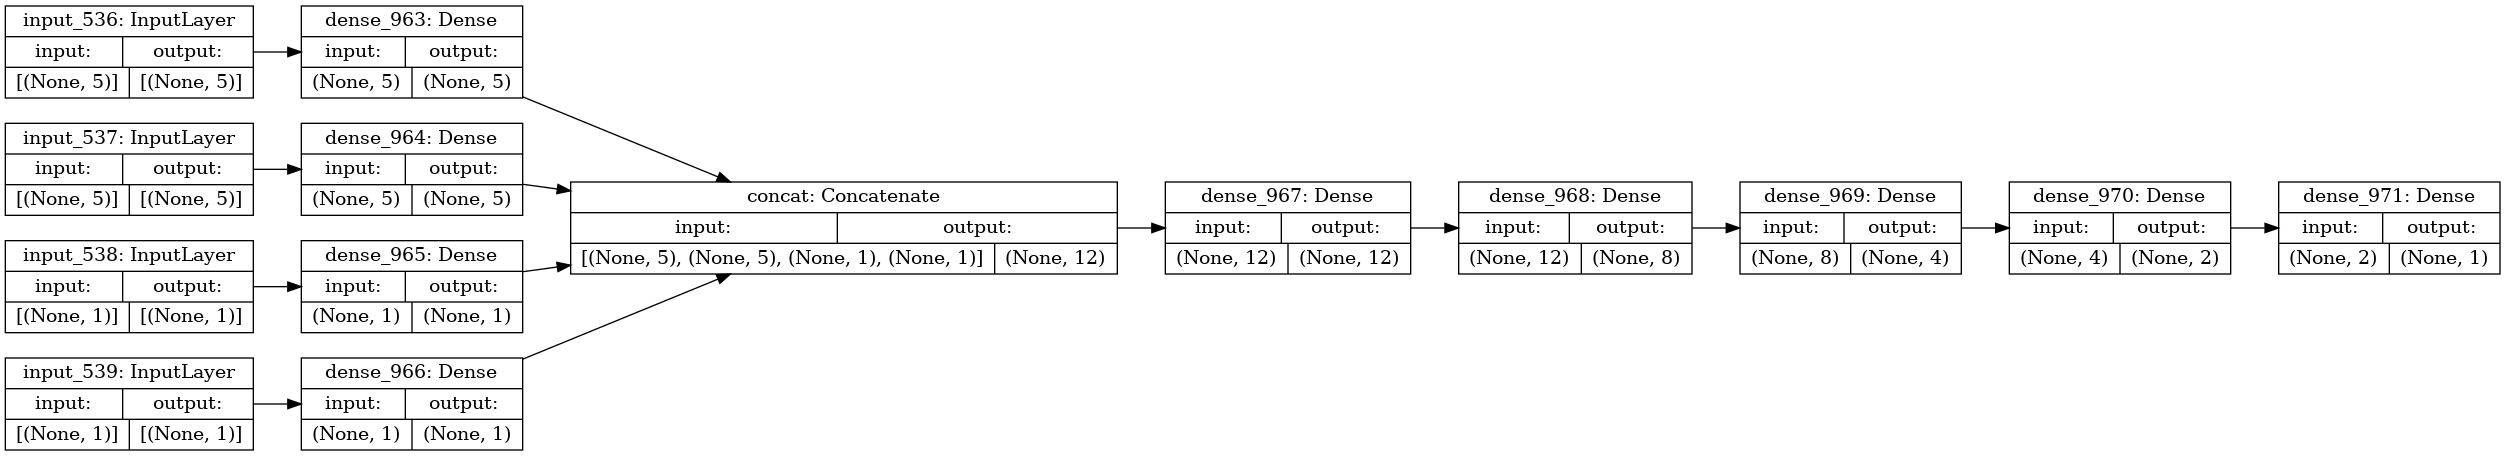

In [10]:
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(network.comb_net, show_shapes=True, show_layer_names=True,rankdir='LR', dpi=96, expand_nested=True)

In [11]:
batch_size, epochs, learning_rate, activation = max(res_dict, key =  res_dict.get)    
print("batch size:", batch_size)
print("epochs:", epochs)
print("learning_rate:", learning_rate)
print("activation:", activation)

batch size: 32
epochs: 500
learning_rate: 5
activation: swish


In [12]:
for i in range(len(data_blocks)):
    sc = StandardScaler()
    if data_blocks[i].ndim == 1:
        print(type(data_blocks[i]), "yes")
        data_blocks[i] = data_blocks[i].values
        data_blocks_test[i] = data_blocks_test[i].values
        data_blocks[i] = data_blocks[i].reshape(-1,1)
        data_blocks_test[i] = data_blocks_test[i].reshape(-1,1)
    data_blocks[i] = sc.fit_transform(data_blocks[i])
    data_blocks_test[i] = sc.transform(data_blocks_test[i])

<class 'pandas.core.series.Series'> yes
<class 'pandas.core.series.Series'> yes


In [13]:
def create_list(num):
        return [None for _ in range(num)]


n = 30

# metrics
rmseiqr = create_list(n)
rmse_q1 = np.quantile(y_test, 0.25)
rmse_q3 = np.quantile(y_test, 0.75)

r2 = create_list(n)

KI = create_list(n)
KO = create_list(n)

vargrad_max = create_list(n)
vargrad_mean = create_list(n)

time_trac = create_list(n)

for i in range(n):
    np.random.seed(i)
    tf.random.set_seed(i)
    
    start = time.time()
    network = build_block_network(data=data_blocks, activation=activation,
                                learning_rate=learning_rate, prob="regression", epochs=epochs)

    network.fit(data_blocks, y_train, epochs=epochs, batch_size=batch_size,
                validation_data = (data_blocks_test,  y_test), verbose=0, problem="regression")
    
    end = time.time()
    time_trac[i] = end-start
    
    pred = network.predict(data_blocks_test)
    rmseiqr[i] = (mean_squared_error(y_test, pred, squared=False)/(rmse_q3-rmse_q1))
    r2[i] = r2_score(y_test, pred)
    
    l = 10 # number of bins
    KI[i] = network.MI(data_blocks, type="mean", eps=1e-100, bins=l, knock_out=False, on_input=False,
                        density=True, plot=False)
    
    KO[i] = np.log2(l) - network.MI(data_blocks, type="mean", eps=1e-100, bins=l, knock_out=True, on_input=False,
                         density=True, plot=False)


    vargrad_max[i] = network.vargrad_input(data_blocks, type="max", seed=i)
    vargrad_mean[i] = network.vargrad_input(data_blocks, type="mean", seed=i)

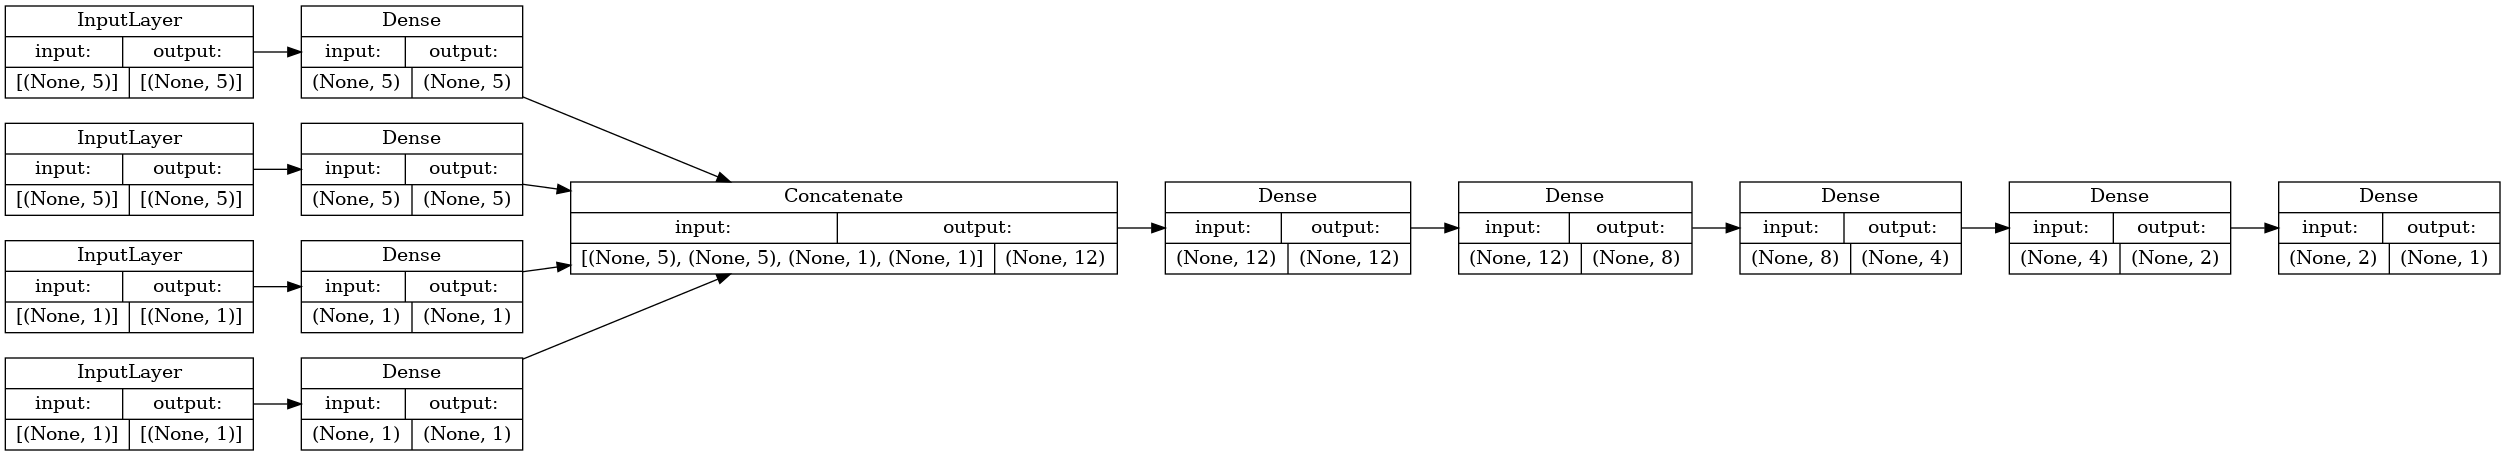

In [14]:
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(network.comb_net, to_file="evaluations/figures/Servo.png", show_shapes=True, show_layer_names=False,rankdir='LR', dpi=96, expand_nested=True)

In [15]:
print("average runtime:", np.round(np.mean(time_trac)), "seconds")

average runtime: 10.0 seconds


In [16]:
print("Mean rmseiqr:", np.mean(rmseiqr), "sd rmseiqr:", np.std(rmseiqr))
print("Mean R2:", np.mean(r2), "sd R2:", np.std(r2))

Mean rmseiqr: 0.22940063100026098 sd rmseiqr: 0.05054719270127529
Mean R2: 0.8463428089774822 sd R2: 0.06905020002331033


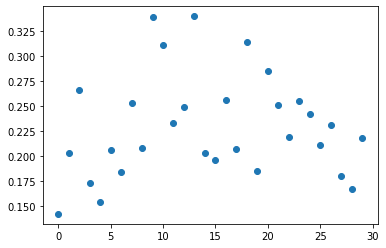

In [17]:
plt.scatter(x=range(n), y = rmseiqr)

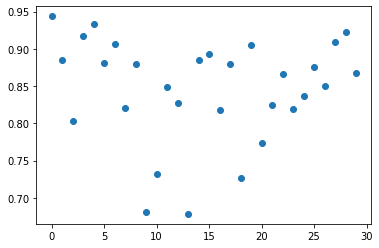

In [18]:
plt.scatter(x = range(n), y = r2)

In [19]:
outliers = np.where(np.array(r2)<0.8)[0]
outliers

array([ 9, 10, 13, 18, 20])

In [20]:
if len(outliers)>=1:
    rmseiqr = remove_outliers(rmseiqr, outliers)
    r2 = remove_outliers(r2, outliers)
    
    t = []
    for i in KO:
        t.append(i.tolist())

    KO = remove_outliers(t, outliers)

    t = []
    for i in KI:
        t.append(i.tolist())

    KI = remove_outliers(t, outliers)
    vargrad_max = remove_outliers(vargrad_max, outliers)
    vargrad_mean = remove_outliers(vargrad_mean, outliers)

In [21]:
print("Mean rmseiqr:", np.mean(rmseiqr), "sd rmseiqr:", np.std(rmseiqr))
print("Mean R2:", np.mean(r2), "sd R2:", np.std(r2))

Mean rmseiqr: 0.21175211627069365 sd rmseiqr: 0.033399795961723634
Mean R2: 0.8720318479240096 sd R2: 0.03887901550779122


In [22]:
pd.DataFrame(np.vstack(KO)).to_csv("raw_results/results_servo/MI_knock_out.csv", index=False)
pd.DataFrame(np.vstack(KI)).to_csv("raw_results/results_servo/MI_knock_in.csv", index=False)
pd.DataFrame(np.vstack(vargrad_max)).to_csv("raw_results/results_servo/vargrad_max.csv", index=False)
pd.DataFrame(np.vstack(vargrad_mean)).to_csv("raw_results/results_servo/vargrad_mean.csv", index=False)

pd.DataFrame(r2).to_csv("raw_results/results_servo/r2.csv", index=False)
pd.DataFrame(rmseiqr).to_csv("raw_results/results_servo/rmseiqr.csv", index=False)

In [23]:
def violinplot_block_importance(measure, name, minimize,title_text=None):
    
    length = np.shape(np.vstack(measure))[0]

    dic = {"Block": list(np.repeat("Block1", length)) + list(np.repeat("Block2", length))
           + list(np.repeat("Block3", length))
                 + list(np.repeat("Block4", length)),
                                                    name : np.column_stack(np.vstack(measure)).reshape(-1,)}
    dic = pd.DataFrame(dic)

    fig, ax =plt.subplots(1,1)
    fig.set_size_inches(15, 10)
    sns.set(font_scale = 2)

    a = sns.boxplot(x="Block", y=name, data=dic, whis=np.inf, palette="Paired")
    sns.swarmplot(x="Block", y=name, data=dic, color=".2", size=6)
    a.set(xlabel=None)
    a.set(title=title_text)

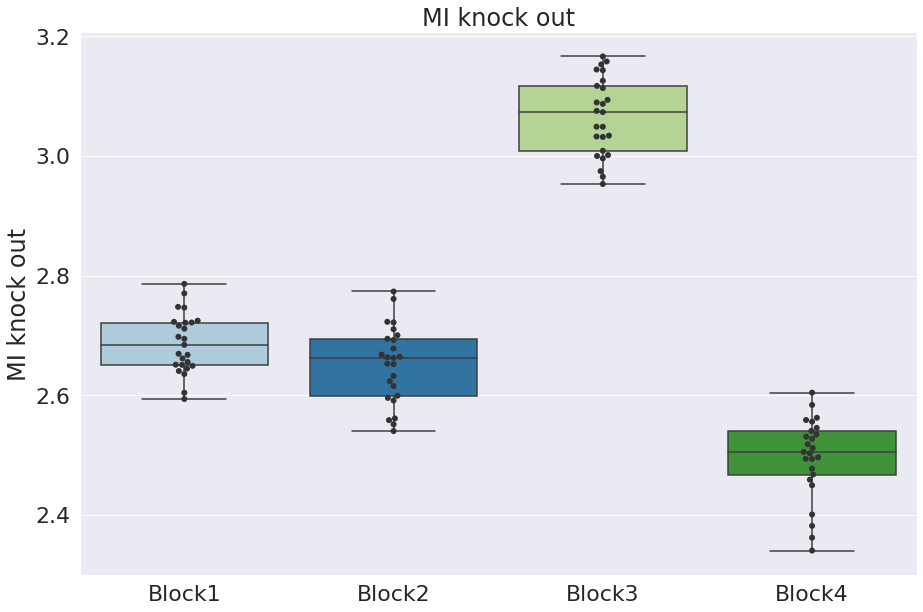

In [28]:
violinplot_block_importance(KO, "MI knock out", minimize=False, title_text = "MI knock out")

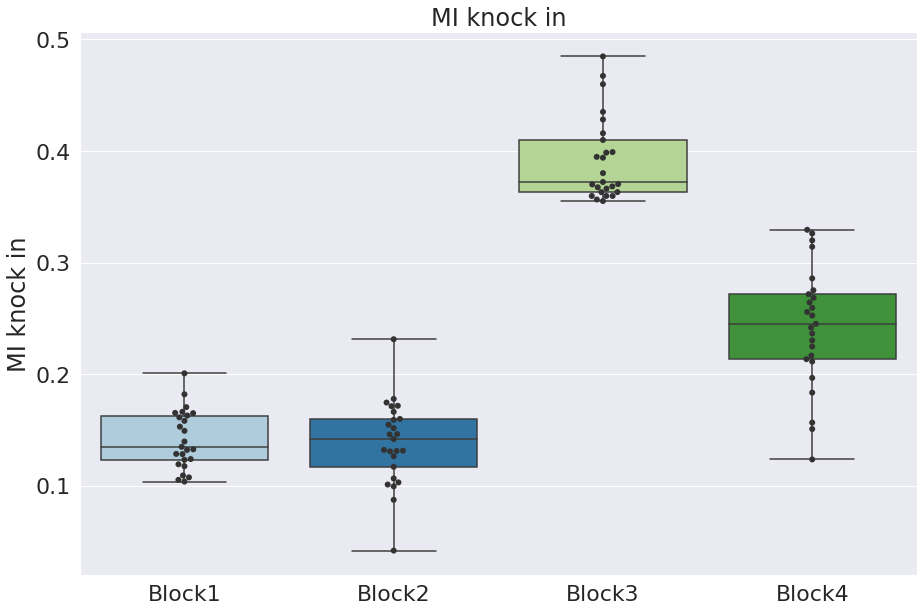

In [25]:
violinplot_block_importance(KI, "MI knock in", minimize=False, title_text = "MI knock in")

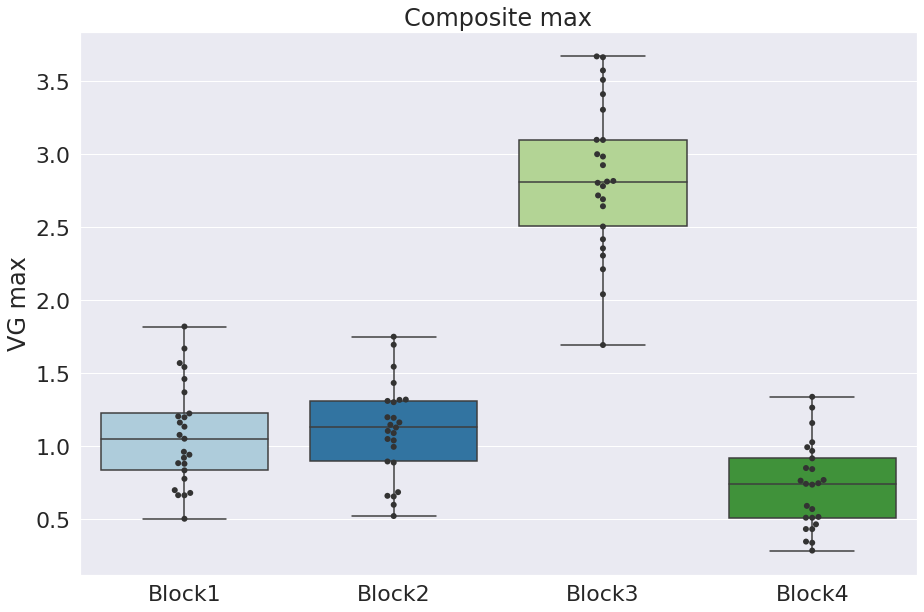

In [26]:
violinplot_block_importance(vargrad_max, "VG max", minimize=False, title_text = "Composite max")

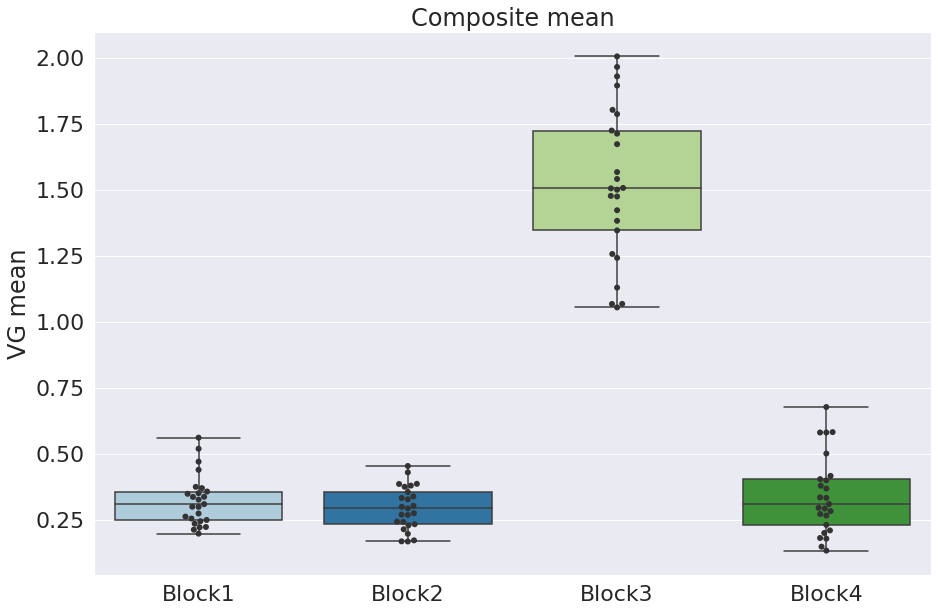

In [27]:
violinplot_block_importance(vargrad_mean, "VG mean", minimize=False, title_text = "Composite mean")